In [1]:
include("../init-notebook.jl")

(section-diffusion-methodlines)=
# The method of lines

Our strategy in {numref}`section-diffusion-blackscholes` was to discretize both the time and space derivatives using finite differences, then rearrange so that we could march the solution forward through time. It was partially effective, but as {numref}`Demo %s <demo-blackscholes-unstable>` shows, not a sure thing, for reasons we look into starting in the next section. 

```{index} ! boundary conditions; periodic
```
First, though, we want to look at a broader version of the discretization approach. To introduce ideas, let's use the simpler heat equation, $u_t = u_{xx}$, as a model. Because boundaries always complicate things, we will start by doing the next best thing to having no boundaries at all: **periodic end conditions**. Specifically, we will solve the PDE over $0\le x < 1$ and require at all times that

$$
u(x+1,t)=u(x,t) \quad \text{for all $x$}.
$$

This is a little different from simply $u(1,t)=u(0,t)$, as {numref}`figure-periodicfun` illustrates.

:::{figure-md} figure-periodicfun
<img src="figures/periodicfun.svg" alt="periodic function illustration">

Left: A function whose values are the same at the endpoints of an interval does not necessarily extend to a smooth periodic function. Right: For a truly periodic function, the function values and all derivatives match at the endpoints of one period.
:::

## Semidiscretization

As always, we use $\hat{u}$ when we specifically refer to the exact solution of the PDE. In order to avoid carrying along redundant information about the function, we use $x_i = ih$ only for $i=0,\ldots,m-1$, where $h=1/m$, and it's understood that a reference to $x_m$ is silently translated to one at $x_0$. More generally, we have the identity

:::{math}
  :label: periodicmod
  \hat{u}(x_i,t) = \hat{u}\bigl(x_{(i \bmod{m})},t \bigr)
:::

to the exact solution $\hat{u}$ for any value of $i$.

```{index} ! semidiscretization; see method of lines
```
```{index} finite difference; for parabolic PDE, differentiation matrix
```

Next we define a vector $\mathbf{u}$ by 

$$
\mathbf{u}(t) = \begin{bmatrix} u_0(t) \\ u_1(t) \\ \vdots \\ u_n(t) \end{bmatrix}.
$$

This step is called **semidiscretization**, since space is discretized but time is not. As in [Chapter 10](../bvp/overview.md), we will replace $u_{xx}$ with multiplication of $\mathbf{u}$ by a differentiation matrix $\mathbf{D}_{xx}$. The canonical choice is the three-point finite difference formula {eq}`centerFD22`, which in light of the periodicity {eq}`periodicmod` leads to 

:::{math}
:label: heatFD22
\mathbf{D}_{xx} = \frac{1}{h^2}
  \begin{bmatrix}
  -2 & 1 & & & 1 \\
  1 & -2 & 1 & & \\
  & \ddots & \ddots & \ddots & \\
  & & 1 & -2 & 1 \\
  1 &  & & 1 & -2
  \end{bmatrix}.
:::

Note well how the first and last rows have elements that "wrap around" from one end of the domain to the other by periodicity. Because we will be using this matrix quite a lot, we create {numref}`Function {number} <function-diffper>` to compute it, as well as the corresponding second-order matrix $\mathbf{D}_x$ for periodic end conditions.

(function-diffper)=
````{proof:function} diffper
**Differentiation matrices for periodic end conditions**
```{code-block} julia1
:lineno-start: 1
"""
    diffper(n,xspan)

Construct 2nd-order differentiation matrices for functions with
periodic end conditions, using `n` unique nodes in the interval
`xspan`. Returns a vector of nodes and the matrices for the first
and second derivatives.
"""
function diffper(n,xspan)
    a,b = xspan
    h = (b-a)/n
    x = @. a + h*(0:n-1)   # nodes, omitting the repeated data

    # Construct Dx by diagonals, then correct the corners.
    dp = fill(0.5/h,n-1)        # superdiagonal
    dm = fill(-0.5/h,n-1)       # subdiagonal
    Dx = diagm(-1=>dm,1=>dp)
    Dx[1,n] = -1/(2*h)
    Dx[n,1] = 1/(2*h)

    # Construct Dxx by diagonals, then correct the corners.
    d0 =  fill(-2/h^2,n)        # main diagonal
    dp =  ones(n-1)/h^2         # superdiagonal and subdiagonal
    Dxx = diagm(-1=>dp,0=>d0,1=>dp)
    Dxx[1,n] = 1/(h^2)
    Dxx[n,1] = 1/(h^2)

    return x,Dx,Dxx
end
```
````

The PDE $u_t=u_{xx}$ is now approximated by the semidiscrete problem

:::{math}
  :label: heatMOL
  \frac{d \mathbf{u}(t)}{d t} = \mathbf{D}_{xx} \mathbf{u}(t),
:::

which is simply a linear, constant-coefficient system of *ordinary* differential equations. Given the initial values $\mathbf{u}(0)$ obtained from $u(x_i,0)$, we have an initial-value problem that we already know how to solve!

```{index} ! method of lines
```
Semidiscretization is often called the **method of lines**. Despite the name, it is not exactly a single method, because both space and time discretizations have to be specified in order to get a concrete algorithm. The key concept is the separation of those two discretizations, and in that way, it's related to separation of variables in analytic methods for the heat equation.

(example-methodlines-heatFE)=
::::{proof:example}
Suppose we solve {eq}`heatMOL` using the Euler IVP integrator {eq}`euler1` from {numref}`section-ivp-euler` (and also AB1 from {numref}`section-ivp-multistep`). We select a time step $\tau$ and discrete times $t_j=j\tau$, $j=0,1,\ldots,n$. We can discretize the vector $\mathbf{u}$ in time as well to get a sequence $\mathbf{u}_j \approx \mathbf{u}(t_j)$ for varying $j$. (Remember the distinction in notation between $\mathbf{u}_j$, which is a vector, and $u_j$, which is a single element of a vector.) 

Thus, a fully discrete method for the heat equation is 
:::{math}
:label: Eulerxx
\mathbf{u}_{j+1} = \mathbf{u}_j + \tau ( \mathbf{D}_{xx} \mathbf{u}_j) = (\mathbf{I} + \tau \mathbf{D}_{xx} ) \mathbf{u}_j.
:::
::::


(demo-methodlines-heatFE)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

Let's implement the method of {numref}`Example {number} <example-methodlines-heatFE>` with second-order space semidiscretization.

In [2]:
m = 100
x,Dx,Dxx = FNC.diffper(m,[0,1]);

tfinal = 0.16;  n = 2400;  
τ = tfinal/n;  t = τ*(0:n);

Next we set an initial condition. It isn't mathematically periodic, but the end values and derivatives are so small that for numerical purposes it may as well be.

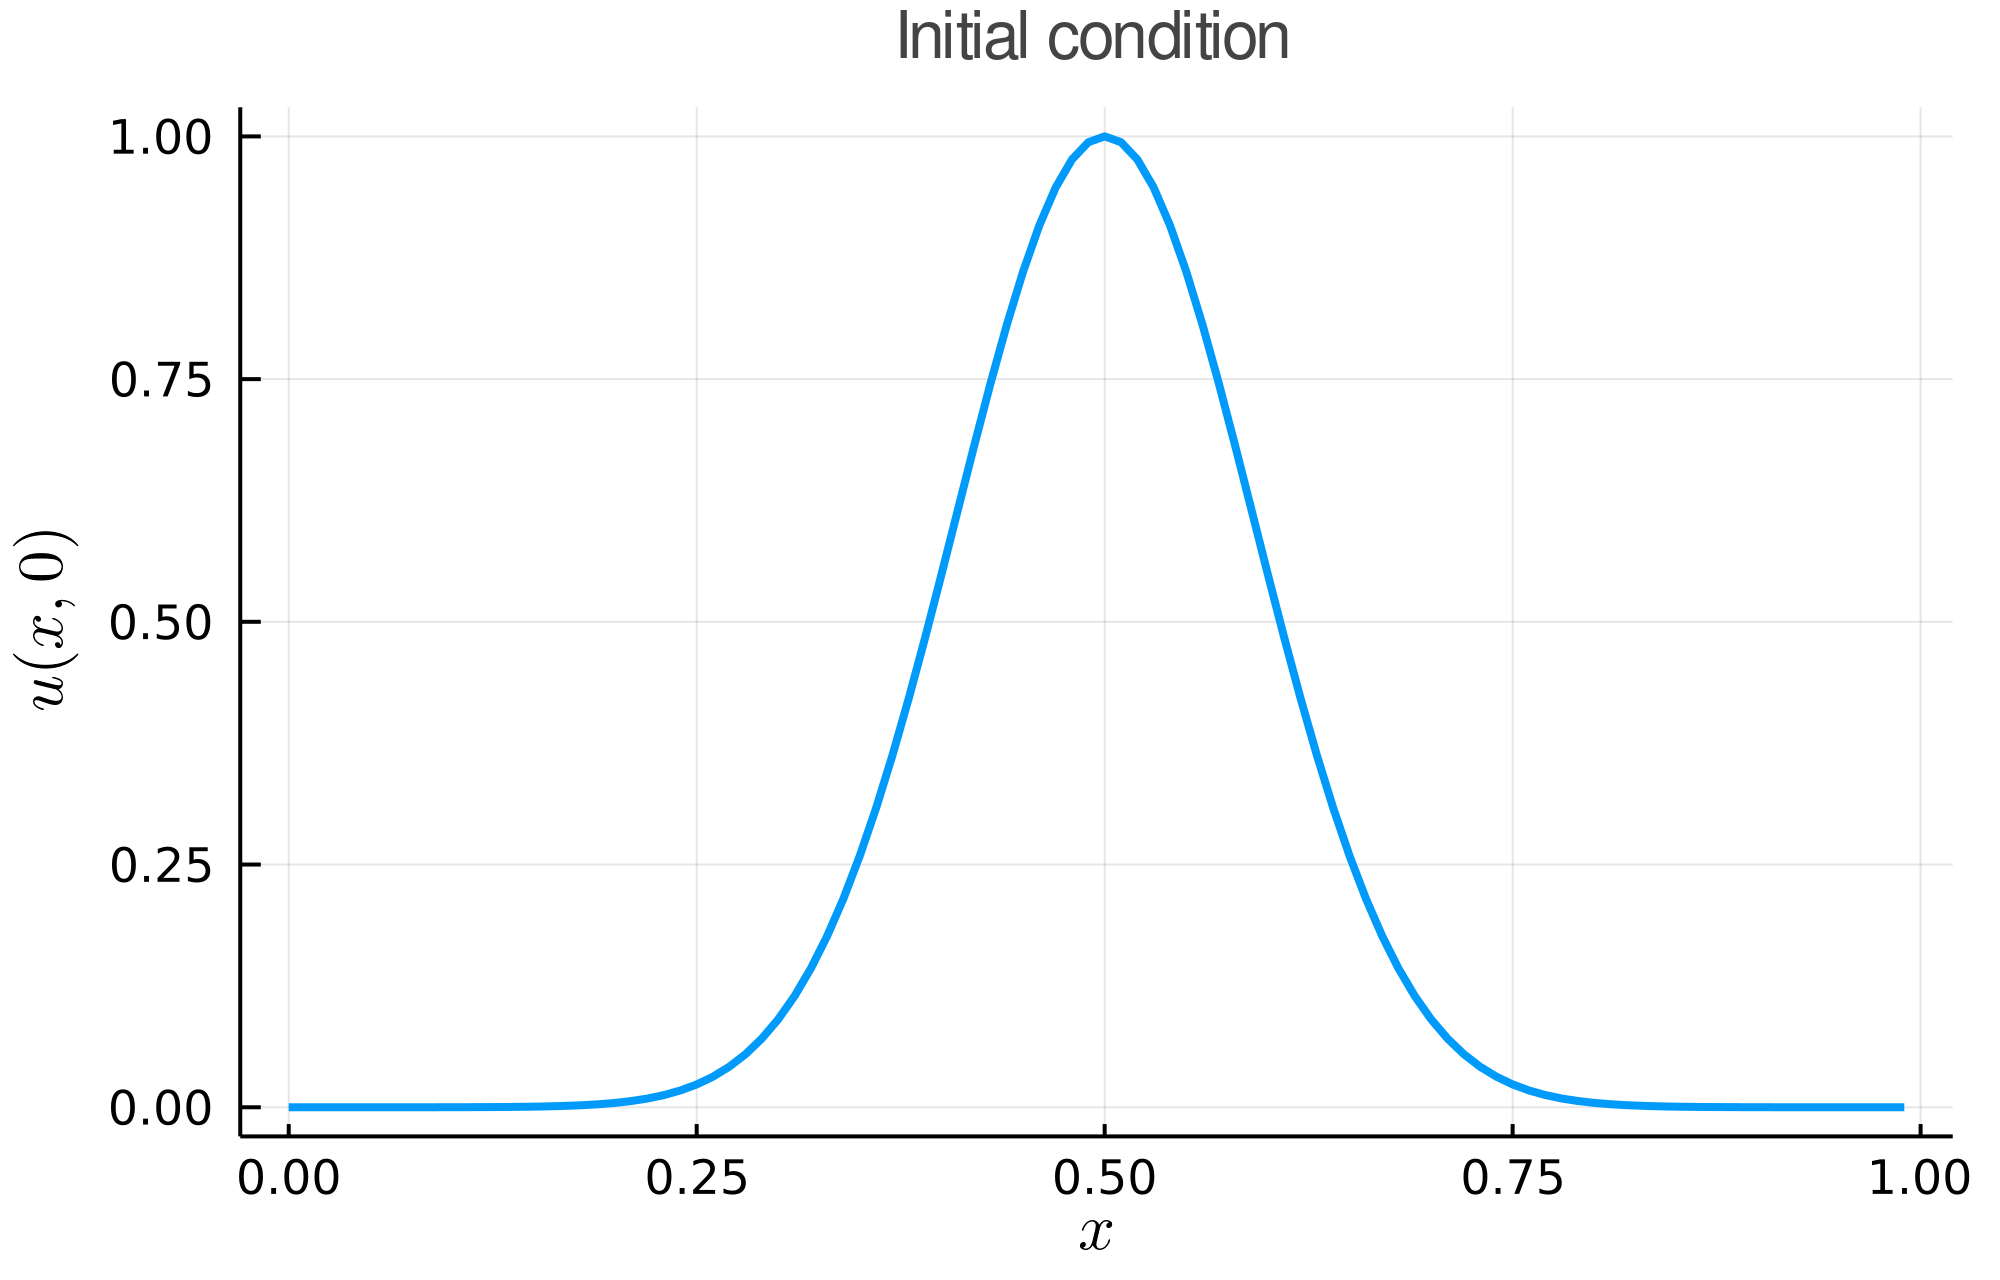

In [3]:
U = zeros(m,n+1);
U[:,1] = @. exp( -60*(x-0.5)^2 )
plot(x,U[:,1],xaxis=(L"x"),yaxis=(L"u(x,0)"),
    title="Initial condition")

The Euler time stepping simply multiplies by the constant matrix in {eq}`Eulerxx` at each time step. Since that matrix is sparse, we will declare it as such, even though the run-time savings may not be detectable for this small value of $m$.

In [4]:
A = sparse(I + τ*Dxx)
for j in 1:n
    U[:,j+1] = A*U[:,j]
end

Things seem to start well, with the initial peak widening and shrinking. But then there is a nonphysical growth in the solution.

In [5]:
anim = @animate for j in 1:101
    plot(x,U[:,j],label=@sprintf("t=%.5f",t[j]),
    xaxis=(L"x"),yaxis=(L"u(x,t)",[-1,3]),dpi=100,
    title="Heat equation by forward Euler")
end
mp4(anim,"diffusionFE.mp4")

Plots.AnimatedGif("/Users/driscoll/repos/fnc-julia/diffusion/diffusionFE.mp4")

The growth in norm is exponential in time.

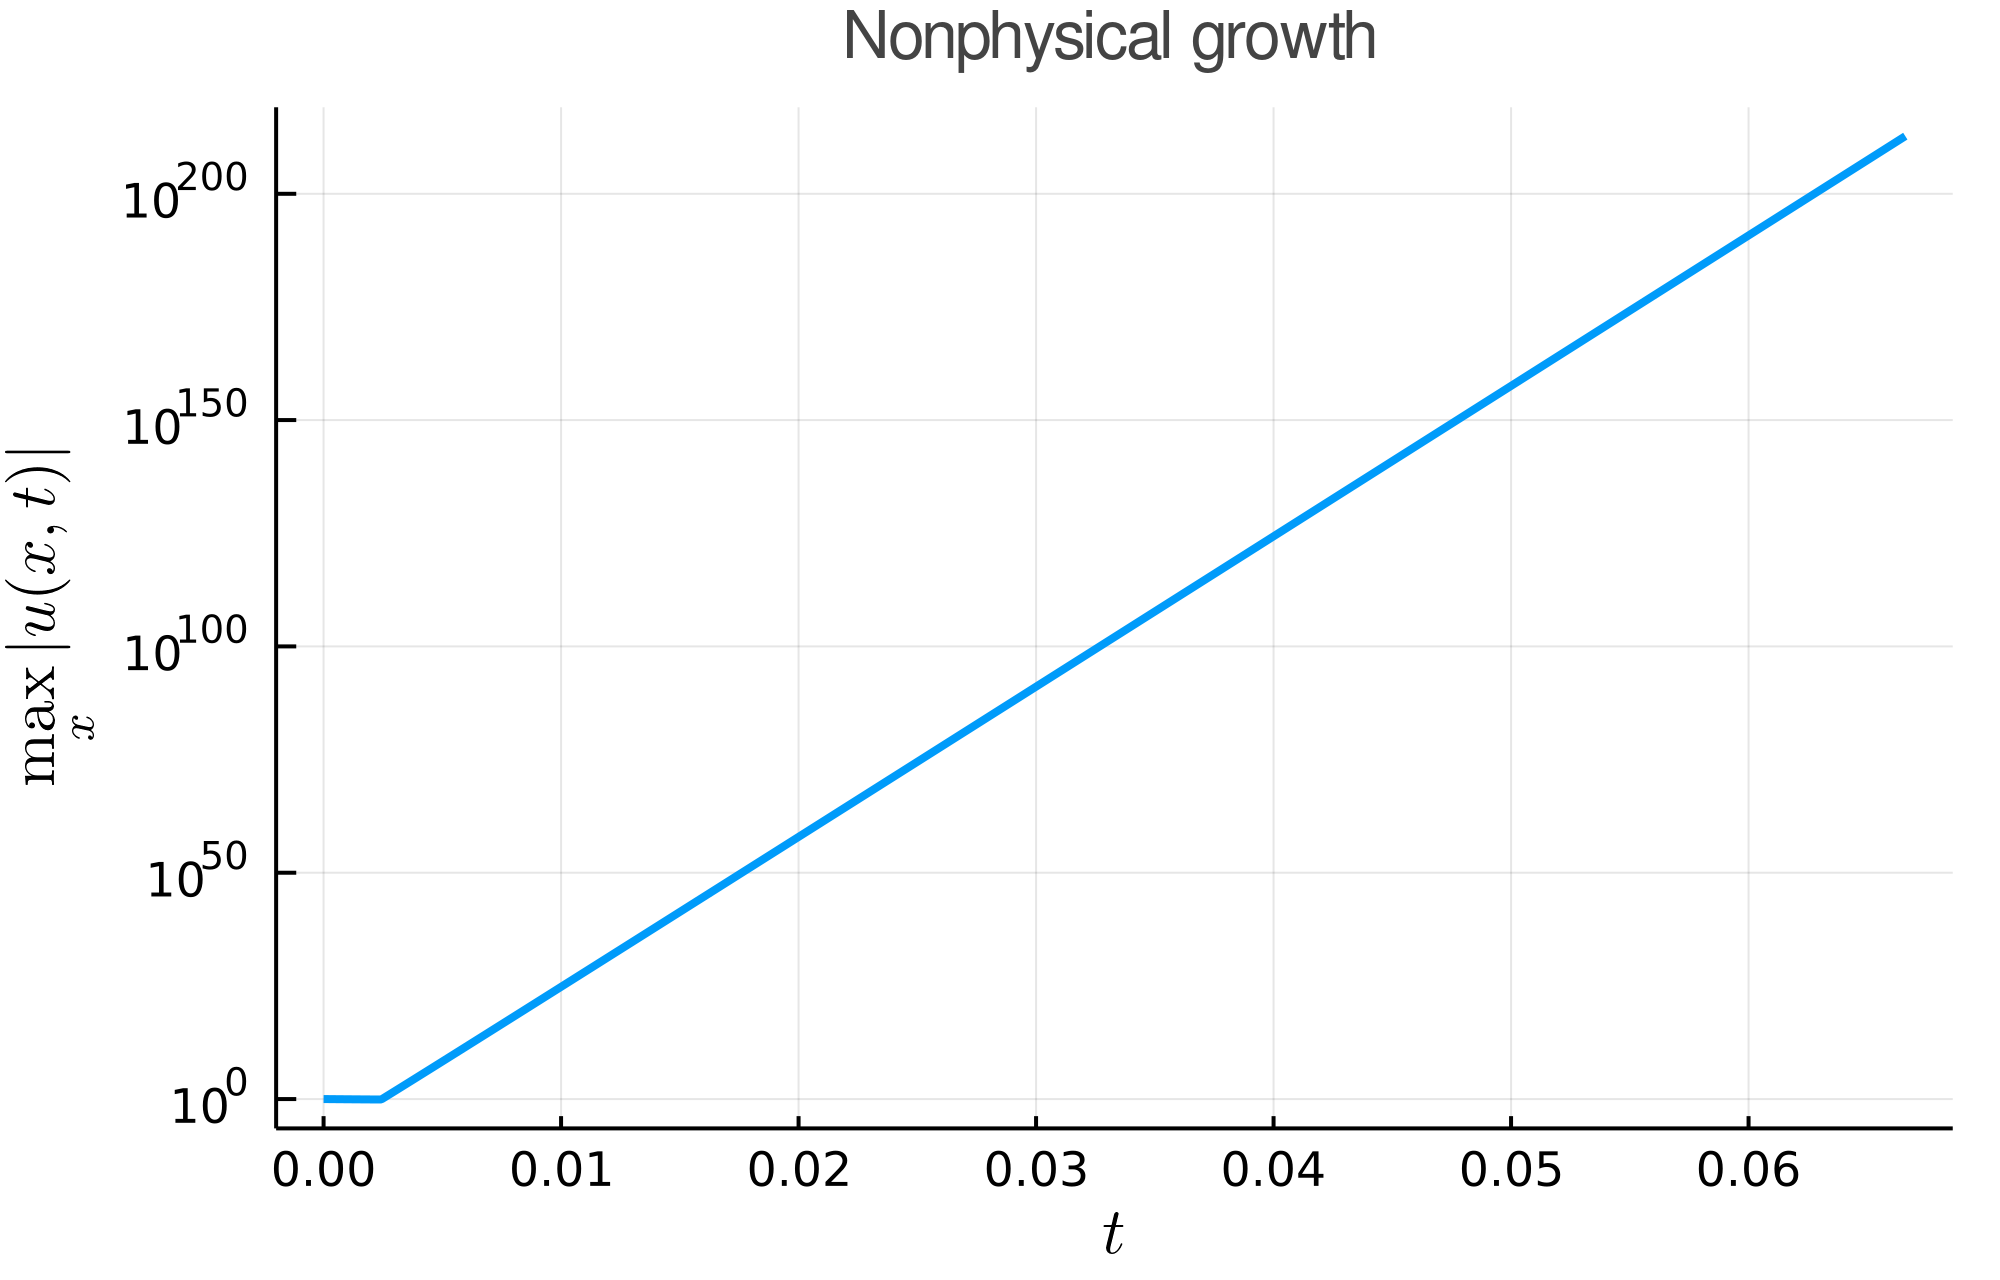

In [6]:
M = vec( maximum(abs,U,dims=1) )   
plot(t[1:1000],M[1:1000],
    xaxis=(L"t"), yaxis=(:log10,L"\max_x |u(x,t)|"),
    title="Nonphysical growth") 

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

The method in {numref}`Example {number} <example-methodlines-heatFE>` and {numref}`Demo {number} <demo-methodlines-heatFE>` is essentially the same one we used for the Black–Scholes equation in {numref}`section-diffusion-blackscholes`. By changing the time integrator, we can get much better results.

(example-methodlines-heatBE)=
::::{proof:example}
An alternative time discretization of {eq}`heatMOL` is to use the backward Euler (AM1) method, resulting in

:::{math}
:label: BExx
\begin{split}
    \mathbf{u}_{j+1} &= \mathbf{u}_j + \tau (\mathbf{D}_{xx} \mathbf{u}_{j+1})\\
    (\mathbf{I} - \tau \mathbf{D}_{xx}) \mathbf{u}_{j+1} &= \mathbf{u}_j.
\end{split}
:::

Because backward Euler is an implicit method, a linear system must be solved for $\mathbf{u}_{j+1}$ at each time step. 
::::


(demo-methodlines-heatBE)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

Now we apply backward Euler to the heat equation. We will reuse the setup from {numref}`Demo {number} <demo-methodlines-heatFE>`. Since the matrix in {eq}`BExx` never changes during the time stepping, we do the necessary LU factorization only once.

In [7]:
B = sparse(I - τ*Dxx)
factor = lu(B)
for j in 1:n
    U[:,j+1] = factor\U[:,j]
end

anim = @animate for j in 1:20:n+1
    plot(x,U[:,j],label=@sprintf("t=%.5f",t[j]),
    xaxis=(L"x"),yaxis=(L"u(x,t)",[0,1]),dpi=100,
    title="Heat equation by backward Euler")
end
mp4(anim,"diffusionBE.mp4")

Plots.AnimatedGif("/Users/driscoll/repos/fnc-julia/diffusion/diffusionBE.mp4")

This solution looks physically plausible, as the large concentration in the center diffuses outward until the solution is essentially constant. Observe that the solution remains periodic in space for all time.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


{numref}`Demo %s <demo-methodlines-heatBE>` suggests that implicit time stepping methods have an important role in diffusion. We will analyze the reason in the next few sections.

## Black-box IVP solvers

Instead of coding one of the Runge–Kutta or multistep formulas directly for a method of lines solution, we could use any of the IVP solvers from Chapter 6, or a solver from the `DifferentialEquations` package, to solve the ODE initial-value problem {eq}`heatMOL`.

(demo-methodlines-auto)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We set up the semidiscretization and initial condition in $x$ just as before.

In [8]:
m = 100
x,Dx,Dxx = FNC.diffper(m,[0,1])
u0 = @. exp( -60*(x-0.5)^2 );

Now, however, we apply {numref}`Function {number} <function-rk23>` to the initial-value problem $\mathbf{u}'=\mathbf{D}_{xx}\mathbf{u}$.

In [9]:
tfinal = 0.25
ODE = (u,p,t) -> Dxx*u;  
IVP = ODEProblem(ODE,u0,(0,tfinal))

t,u = FNC.rk23(IVP,1e-5);

We check that the resulting solution looks realistic.

In [10]:
anim = @animate for j in 1:20:1600
    plot(x,u[j],label=@sprintf("t=%.4f",t[j]),
      xaxis=(L"x"), yaxis=(L"u(x,t)",[0,1]),dpi=100,
      title="Solution via rk23")
end
mp4(anim,"diffusionRK23.mp4")

Plots.AnimatedGif("/Users/driscoll/repos/fnc-julia/diffusion/diffusionRK23.mp4")

The solution appears to be correct. But the number of time steps that were selected automatically is surprisingly large, considering how smoothly the solution changes.

In [11]:
println("Number of time steps for RK23: $(length(t)-1)")

Number of time steps for RK23: 3975


Now we apply a solver from `DifferentialEquations`.

In [12]:
u = solve(IVP,Rodas4P());
println("Number of time steps for Rodas4P: $(length(u.t)-1)")

Number of time steps for Rodas4P: 23


The number of steps selected is reduced by a factor of more than 100!
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

The adaptive time integrators can all produce solutions. But, as seen in {numref}`Demo %s <demo-methodlines-auto>`, they are not equivalent in every important sense. Whether we choose to implement a method directly with a fixed step size, or automatically with adaptation, there is something crucial to understand about the semidiscrete problem {eq}`heatMOL` that will occupy our attention in the next two sections.

## Exercises

1. ⌨ Revisit {numref}`Demo {number} <demo-methodlines-heatFE>`. For each $m=20,30,\dots,120$ points in space, let $n=20,30,40,\dots$ in turn until you reach the smallest $n$ such that the numerical solution remains bounded above by 2 for all time; call this value $N(m)$. Make a log–log plot of $N(m)$ as a function of $m$. If you suppose that $N=O(m^p)$ for a simple rational number $p$, what is a reasonable hypothesis for $p$?

2. In {numref}`Demo {number} <demo-methodlines-auto>`, as $t\to \infty$ the solution $u(x,t)$ approaches a value that is constant in both space and time.

    **(a)** ⌨ Set $m=400$ and use `Rodas4P`, as shown in {numref}`Demo {number} <demo-methodlines-auto>`, to find this constant value to at least eight digits of accuracy.

    **(b)** ✍ Prove that $\int_0^1 u(x,t) \,dx$ is constant in time.

    **(c)** ⌨ Use {numref}`Function {number} <function-trapezoid>` on the initial condition function, and compare to the result of part (a).

    ```{index} Crank–Nicolson method
    ```
3. ✍ Apply the trapezoid IVP formula (AM2) to the semidiscretization {eq}`heatMOL` and derive what is known as the *Crank–Nicolson* method:

    :::{math}
    :label: CNxx
    (\mathbf{I} - \tfrac{1}{2}\tau \mathbf{D}_{xx}) \mathbf{u}_{j+1} =  (\mathbf{I} + \tfrac{1}{2}\tau
    \mathbf{D}_{xx}) \mathbf{u}_{j}.
    :::

    Note that each side of the method is evaluated at a different time level.

4. ⌨ Repeat {numref}`Demo %s <demo-methodlines-heatBE>` using the Crank–Nicolson method {eq}`CNxx`. Then try for $n=240$ as well, which uses a time step ten times larger than before. Does the solution remain stable? 

5. The PDE $u_t = 2u + u_{xx}$ combines growth with diffusion. 

    **(a)** ✍ Derive an equation analogous to {eq}`BExx` that combines second-order semidiscretization in space with the backward Euler solver in time.

    **(b)** ⌨ Apply your formula from part (a) to solve this PDE with periodic boundary conditions for the same initial condition as in {numref}`Demo {number} <demo-methodlines-heatBE>`. Use  $m=200$ points in space and $n=1000$ time levels. Plot the solution on one graph at times $t=0,0.04,0.08,\ldots,0.2$, or animate the solution over $0\le t \le 0.2$.

6. ✍ In this problem, you will analyze the convergence of the explicit method given by {eq}`Eulerxx`.  Recall that the discrete approximation $u_{i,j}$ approximates the solution at $x_i$ and $t_j$.

    **(a)** Write the method in scalar form as
        
    $$
    u_{i,j+1} = (1-2\lambda) u_{i,j} + \lambda u_{i+1,j} + \lambda u_{i-1,j},
    $$

     where $\lambda = \tau/h^2>0$.
    
    **(b)** Taylor series of the exact solution $\hat{u}$ imply that
      
      \begin{align*}
        \hat{u}_{i,j+1} &= u_{i,j} + \frac{\partial \hat{u}}{\partial t} (x_i,t_j) \tau + O(\tau^2)\\
        % \frac{\partial^2 u}{\partial t^2} (x_i,\bar{t}) \frac{\tau^2}{2}
          \hat{u}_{i\pm1,j} &= \hat{u}_{i,j} \pm \frac{\partial \hat{u}}{\partial x} (x_i,t_j) h + \frac{\partial^2 \hat{u}}{\partial x^2} (x_i,t_j)
      \frac{h^2}{2} \pm \frac{\partial^3 \hat{u}}{\partial x^3} (x_i,t_j)
      \frac{h^3}{6}+  O(h^4).
      %\frac{\partial^4 u}{\partial x^4} (\bar{x}_\pm,t_j) \frac{h^4}{24}.
      \end{align*}
      
      Use these to show that
      
      \begin{align*}
          \hat{u}_{i,j+1} & = \left[ (1-2\lambda) \hat{u}_{i,j} + \lambda \hat{u}_{i+1,j} + \lambda \hat{u}_{i-1,j}\right]
          +  O\Bigl(\tau^2+h^2 \Bigr)\\
          &= F\left( \lambda,\hat{u}_{i,j}, \hat{u}_{i+1,j} , \hat{u}_{i-1,j}\right) + O\Bigl(\tau^2+h^2\Bigr).
      \end{align*}
      
      (The last line should be considered a definition of the function $F$.)
    
    **(c)** The numerical solution satisfies 
    
    $$
    u_{i,j+1}=F\bigl( \lambda,u_{i,j}, u_{i+1,j} , u_{i-1,j}\bigr) 
    $$ 
    
    exactly. Using this fact, subtract $u_{i,j+1}$ from both sides of the last line in part (b) to show that
    
    $$
        e_{i,j+1} = F\left( \lambda,e_{i,j}, e_{i+1,j} ,e_{i-1,j}\right)  + O\Bigl(\tau^2+h^2\Bigr),
    $$

    where $e_{i,j}=\hat{u}_{i,j}-u_{i,j}$ is the error in the numerical solution for all $i$ and $j$ .
    
    **(d)** Define $E_j$ as the maximum of $|e_{i,j}|$ over all values of $i$, and use the result of part (c) to show that if $\lambda<1/2$ is kept fixed as $h$ and $\tau$ approach zero, then for sufficiently small $\tau$ and $h$,
    
    $$
      E_{j+1}  = E_{j} + O\Bigl(\tau^2+h^2\Bigr) \le E_{j} + K_j\bigl(\tau^2+h^2\bigr)
    $$

    for a positive $K_j$ independent of $\tau$ and $h$.
    
    **(e)** If the initial conditions are exact, then $E_0=0$. Use this to show finally that if the $K_j$ are bounded above and $\lambda<1/2$ is kept fixed, then $E_n = O(\tau)$ as $\tau\to 0$.